# **Homework 8 - Anomaly Detection**

If there are any questions, please contact mlta-2022spring-ta@googlegroups.com

Slide:    [Link]()　Kaggle: [Link](https://www.kaggle.com/c/ml2022spring-hw8)

# Set up the environment


## Package installation

In [ ]:
# Training progress bar
!pip install -q qqdm

## Downloading data

In [ ]:
!wget https://github.com/MachineLearningHW/HW8_Dataset/releases/download/v1.0.0/data.zip

In [ ]:
!unzip data.zip

# Import packages

In [1]:
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models
import torchvision
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Loading data

In [2]:
train = np.load('data/trainingset.npy', allow_pickle=True)
test = np.load('data/testingset.npy', allow_pickle=True)

print(train.shape)
print(test.shape)

(100000, 64, 64, 3)
(19636, 64, 64, 3)


## Random seed
Set the random seed to a certain value for reproducibility.

In [3]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(48763)

# Autoencoder

# Models & loss

In [4]:
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Size: (Batch, 64 * 64 * 3)
            nn.Linear(64 * 64 * 3, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            # Size: (Batch, 4096)
            nn.Linear(4096, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            # Size: (Batch, 2048)
        )
        
        self.decoder = nn.Sequential(
            # Size: (Batch, 2048)
            nn.Linear(2048, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            # Size: (Batch, 4096)
            nn.Linear(4096, 64 * 64 * 3), 
            nn.Tanh()
            # Size: (Batch, 64 * 64 * 3)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class UpsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=2, padding=1):
        super(UpsampleBlock, self).__init__()
        self.upsample = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.upsample(x)
        return x

class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        """
        Conv2d output size: [Height + 2 * padding - dilation * (kernel_size - 1) - 1] / stride + 1
        """
        self.encoder = nn.Sequential(
            # Size: (Batch, 3, 64, 64)
            nn.Conv2d(3, 12, 30, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # Size: (Batch, 12, 19, 19)
        )

        self.encoder1 = nn.Sequential(
            # Size: (Batch, 3, 64, 64)
            nn.Conv2d(3, 12, 40, stride=2, padding=1),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            # Size: (Batch, 12, 14, 14)
        )

        """
        ConvTranspose2d output size: (Height - 1) * stride - 2 * padding + kernel_size
        """
        self.decoder = nn.Sequential(
            # Size: (Batch, 12, 19, 19)
            nn.ConvTranspose2d(12, 3, 30, stride=2, padding=1),
            nn.BatchNorm2d(3),
            nn.Tanh(),
            # Size: (Batch, 3, 64, 64)
        )

    def forward(self, x):
        device = x.device
        x1, x2 = self.encoder(x), self.encoder1(x)
        batch, C, H, W = x1.size()

        # # Use ConvTranspose2d to make the dimension of feature maps consistent.
        # upsample = UpsampleBlock(C, C, 8, 1, 1).to(device)
        # x2 = upsample(x2)

        # Use interpolate to make the dimension of feature maps consistent.
        x2 = F.interpolate(x2, size=(H, W), mode='bilinear', align_corners=True)
        x = x1 + x2
        x = self.decoder(x)
        return x

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # Size: (Batch, 3, 64, 64)
            nn.Conv2d(3, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 12, 32, 32)
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 24, 16, 16)
        )
        self.enc_out_1 = nn.Sequential(
            # Size: (Batch, 24, 16, 16)
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 48, 8, 8)
        )
        self.enc_out_2 = nn.Sequential(
            # Size: (Batch, 24, 16, 16)
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 48, 8, 8)
        )
        self.decoder = nn.Sequential(
            # Size: (Batch, 48, 8, 8)
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 24, 16, 16)
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            # Size: (Batch, 12, 32, 32)
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
            # Size: (Batch, 3, 64, 64)
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

# Dataset module

Module for obtaining and processing data. The transform function here normalizes image's pixels from [0, 255] to [-1.0, 1.0].


In [5]:
no_tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((196, 196)),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: 2. * x - 1.),
])

In [6]:
class CustomTensorDataset(TensorDataset):
    """
    TensorDataset with support of transforms.
    """
    def __init__(self, tensors, tfm=None):
        self.tensors = tensors
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2)
        self.transform = tfm
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

# Training

## Configuration


In [7]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Training hyperparameters
num_epochs = 200
batch_size = 32
learning_rate = 1e-4

# Build training dataloader
x = torch.from_numpy(train)
train_dataset = CustomTensorDataset(x, tfm)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=8)

# Model
model_type = 'fcn'   # selecting a model type from {'cnn', 'fcn', 'vae'}
model_classes = {'fcn': fcn_autoencoder(), 'cnn': conv_autoencoder(), 'vae': VAE()}
model = model_classes[model_type].to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Plot sample images

In [8]:
def plot_sample_image(batch_imgs, grid_size=10):
    batch_size = batch_imgs.size(0)
    assert grid_size**2 <= batch_size, "Batch size is smaller than sample size."
    row, col = grid_size, grid_size
    # sample_imgs = random.sample(range(batch_size), grid_size**2)
    sample_imgs = list(range(grid_size**2))
    grid_img = torchvision.utils.make_grid(batch_imgs[sample_imgs].cpu(), nrow=row)
    plt.figure(figsize=(row, col))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


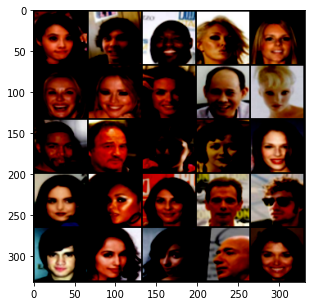

In [9]:
batch_imgs = next(iter(train_dataloader))
plot_sample_image(batch_imgs, grid_size=5)

## Training loop

  0%|          | 0/200 [00:00<?, ?it/s]

Saving Auto-Encoder model in Epoch 1 with loss=0.0473...
Epoch 001/200, loss=0.047350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


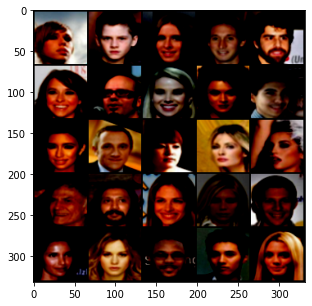

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


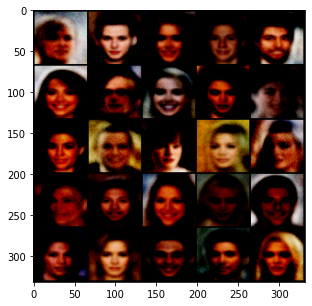

Saving Auto-Encoder model in Epoch 2 with loss=0.0316...
Saving Auto-Encoder model in Epoch 3 with loss=0.0277...
Saving Auto-Encoder model in Epoch 4 with loss=0.0251...
Saving Auto-Encoder model in Epoch 5 with loss=0.0234...
Saving Auto-Encoder model in Epoch 6 with loss=0.0221...
Saving Auto-Encoder model in Epoch 7 with loss=0.0209...
Saving Auto-Encoder model in Epoch 8 with loss=0.0200...
Saving Auto-Encoder model in Epoch 9 with loss=0.0193...
Saving Auto-Encoder model in Epoch 10 with loss=0.0185...
Saving Auto-Encoder model in Epoch 11 with loss=0.0179...
Saving Auto-Encoder model in Epoch 12 with loss=0.0173...
Saving Auto-Encoder model in Epoch 13 with loss=0.0167...
Saving Auto-Encoder model in Epoch 14 with loss=0.0162...
Saving Auto-Encoder model in Epoch 15 with loss=0.0158...
Saving Auto-Encoder model in Epoch 16 with loss=0.0153...
Saving Auto-Encoder model in Epoch 17 with loss=0.0149...
Saving Auto-Encoder model in Epoch 18 with loss=0.0146...
Saving Auto-Encoder mo

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


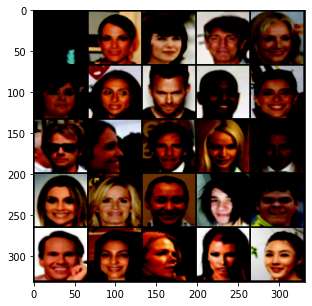

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


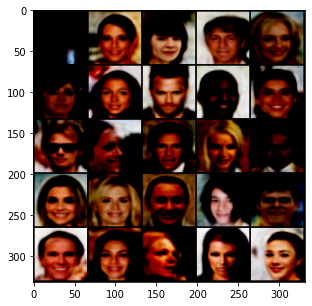

Saving Auto-Encoder model in Epoch 21 with loss=0.0137...
Saving Auto-Encoder model in Epoch 22 with loss=0.0135...
Saving Auto-Encoder model in Epoch 23 with loss=0.0133...
Saving Auto-Encoder model in Epoch 24 with loss=0.0130...
Saving Auto-Encoder model in Epoch 25 with loss=0.0128...
Saving Auto-Encoder model in Epoch 26 with loss=0.0126...
Saving Auto-Encoder model in Epoch 27 with loss=0.0124...
Saving Auto-Encoder model in Epoch 28 with loss=0.0122...
Saving Auto-Encoder model in Epoch 29 with loss=0.0121...
Saving Auto-Encoder model in Epoch 30 with loss=0.0119...
Saving Auto-Encoder model in Epoch 31 with loss=0.0118...
Saving Auto-Encoder model in Epoch 32 with loss=0.0116...
Saving Auto-Encoder model in Epoch 33 with loss=0.0114...
Saving Auto-Encoder model in Epoch 34 with loss=0.0113...
Saving Auto-Encoder model in Epoch 35 with loss=0.0112...
Saving Auto-Encoder model in Epoch 36 with loss=0.0111...
Saving Auto-Encoder model in Epoch 37 with loss=0.0109...
Saving Auto-En

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


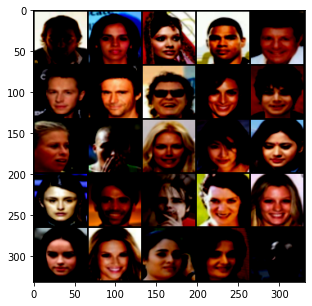

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


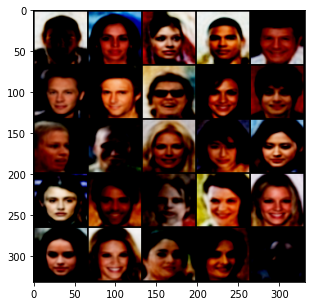

Saving Auto-Encoder model in Epoch 41 with loss=0.0105...
Saving Auto-Encoder model in Epoch 42 with loss=0.0104...
Saving Auto-Encoder model in Epoch 43 with loss=0.0104...
Saving Auto-Encoder model in Epoch 44 with loss=0.0103...
Saving Auto-Encoder model in Epoch 45 with loss=0.0102...
Saving Auto-Encoder model in Epoch 46 with loss=0.0100...
Saving Auto-Encoder model in Epoch 47 with loss=0.0100...
Saving Auto-Encoder model in Epoch 48 with loss=0.0099...
Saving Auto-Encoder model in Epoch 49 with loss=0.0098...
Saving Auto-Encoder model in Epoch 50 with loss=0.0097...
Saving Auto-Encoder model in Epoch 51 with loss=0.0097...
Saving Auto-Encoder model in Epoch 52 with loss=0.0096...
Saving Auto-Encoder model in Epoch 53 with loss=0.0096...
Saving Auto-Encoder model in Epoch 54 with loss=0.0094...
Saving Auto-Encoder model in Epoch 56 with loss=0.0094...
Saving Auto-Encoder model in Epoch 57 with loss=0.0093...
Saving Auto-Encoder model in Epoch 58 with loss=0.0092...
Saving Auto-En

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


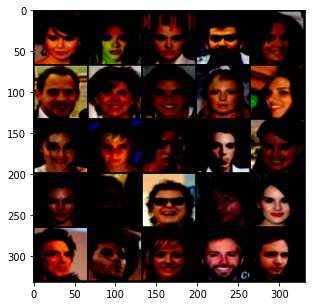

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


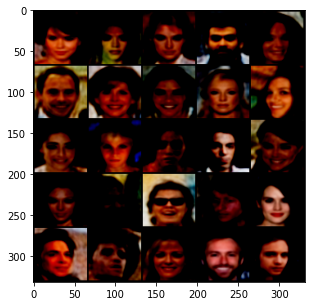

Saving Auto-Encoder model in Epoch 61 with loss=0.0091...
Saving Auto-Encoder model in Epoch 62 with loss=0.0090...
Saving Auto-Encoder model in Epoch 64 with loss=0.0089...
Saving Auto-Encoder model in Epoch 65 with loss=0.0088...
Saving Auto-Encoder model in Epoch 66 with loss=0.0088...
Saving Auto-Encoder model in Epoch 67 with loss=0.0088...
Saving Auto-Encoder model in Epoch 68 with loss=0.0087...
Saving Auto-Encoder model in Epoch 69 with loss=0.0086...
Saving Auto-Encoder model in Epoch 70 with loss=0.0086...
Saving Auto-Encoder model in Epoch 72 with loss=0.0085...
Saving Auto-Encoder model in Epoch 73 with loss=0.0085...
Saving Auto-Encoder model in Epoch 74 with loss=0.0084...
Saving Auto-Encoder model in Epoch 75 with loss=0.0084...
Saving Auto-Encoder model in Epoch 76 with loss=0.0084...
Saving Auto-Encoder model in Epoch 77 with loss=0.0083...
Saving Auto-Encoder model in Epoch 78 with loss=0.0083...
Saving Auto-Encoder model in Epoch 79 with loss=0.0082...
Saving Auto-En

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


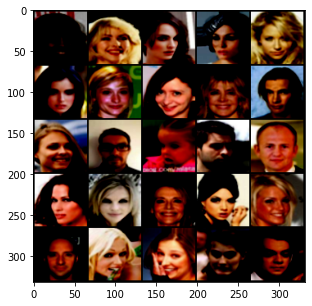

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


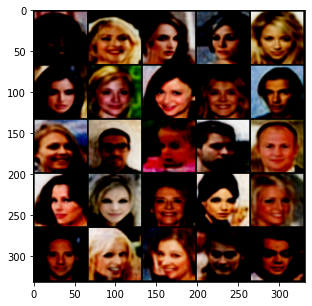

Saving Auto-Encoder model in Epoch 81 with loss=0.0081...
Saving Auto-Encoder model in Epoch 83 with loss=0.0081...
Saving Auto-Encoder model in Epoch 84 with loss=0.0080...
Saving Auto-Encoder model in Epoch 85 with loss=0.0080...
Saving Auto-Encoder model in Epoch 86 with loss=0.0080...
Saving Auto-Encoder model in Epoch 88 with loss=0.0079...
Saving Auto-Encoder model in Epoch 89 with loss=0.0079...
Saving Auto-Encoder model in Epoch 90 with loss=0.0078...
Saving Auto-Encoder model in Epoch 92 with loss=0.0078...
Saving Auto-Encoder model in Epoch 94 with loss=0.0077...
Saving Auto-Encoder model in Epoch 95 with loss=0.0077...
Saving Auto-Encoder model in Epoch 96 with loss=0.0076...
Saving Auto-Encoder model in Epoch 97 with loss=0.0076...
Saving Auto-Encoder model in Epoch 98 with loss=0.0076...
Saving Auto-Encoder model in Epoch 99 with loss=0.0075...
Epoch 100/200, loss=0.007558


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


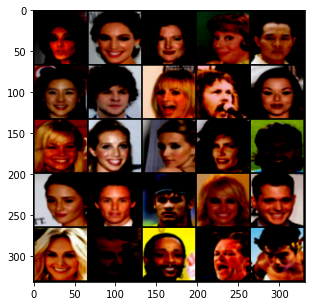

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


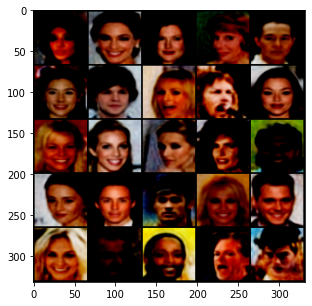

Saving Auto-Encoder model in Epoch 101 with loss=0.0075...
Saving Auto-Encoder model in Epoch 104 with loss=0.0074...
Saving Auto-Encoder model in Epoch 105 with loss=0.0074...
Saving Auto-Encoder model in Epoch 107 with loss=0.0074...
Saving Auto-Encoder model in Epoch 108 with loss=0.0073...
Saving Auto-Encoder model in Epoch 110 with loss=0.0073...
Saving Auto-Encoder model in Epoch 111 with loss=0.0072...
Saving Auto-Encoder model in Epoch 112 with loss=0.0072...
Saving Auto-Encoder model in Epoch 113 with loss=0.0072...
Saving Auto-Encoder model in Epoch 115 with loss=0.0072...
Saving Auto-Encoder model in Epoch 116 with loss=0.0071...
Saving Auto-Encoder model in Epoch 117 with loss=0.0071...
Saving Auto-Encoder model in Epoch 119 with loss=0.0071...
Saving Auto-Encoder model in Epoch 120 with loss=0.0071...
Epoch 120/200, loss=0.007050


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


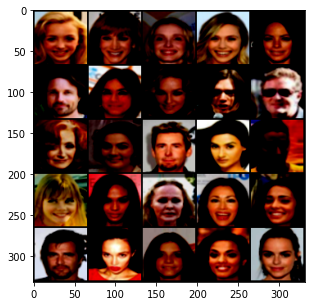

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


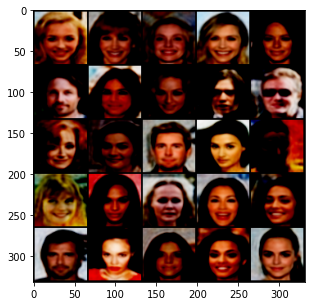

Saving Auto-Encoder model in Epoch 121 with loss=0.0070...
Saving Auto-Encoder model in Epoch 122 with loss=0.0070...
Saving Auto-Encoder model in Epoch 124 with loss=0.0069...
Saving Auto-Encoder model in Epoch 125 with loss=0.0069...
Saving Auto-Encoder model in Epoch 126 with loss=0.0069...
Saving Auto-Encoder model in Epoch 127 with loss=0.0069...
Saving Auto-Encoder model in Epoch 128 with loss=0.0069...
Saving Auto-Encoder model in Epoch 129 with loss=0.0069...
Saving Auto-Encoder model in Epoch 130 with loss=0.0068...
Saving Auto-Encoder model in Epoch 132 with loss=0.0068...
Saving Auto-Encoder model in Epoch 134 with loss=0.0067...
Saving Auto-Encoder model in Epoch 136 with loss=0.0067...
Saving Auto-Encoder model in Epoch 138 with loss=0.0067...
Saving Auto-Encoder model in Epoch 139 with loss=0.0067...
Saving Auto-Encoder model in Epoch 140 with loss=0.0066...
Epoch 140/200, loss=0.006626


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


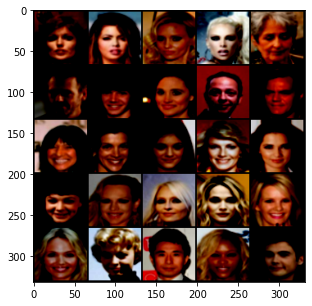

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


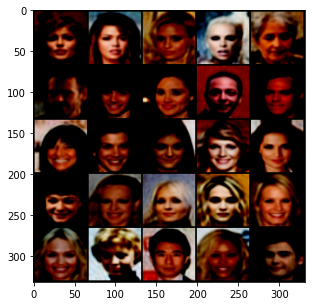

Saving Auto-Encoder model in Epoch 141 with loss=0.0066...
Saving Auto-Encoder model in Epoch 142 with loss=0.0066...
Saving Auto-Encoder model in Epoch 144 with loss=0.0066...
Saving Auto-Encoder model in Epoch 145 with loss=0.0066...
Saving Auto-Encoder model in Epoch 147 with loss=0.0065...
Saving Auto-Encoder model in Epoch 148 with loss=0.0065...
Saving Auto-Encoder model in Epoch 150 with loss=0.0065...
Saving Auto-Encoder model in Epoch 152 with loss=0.0064...
Saving Auto-Encoder model in Epoch 155 with loss=0.0064...
Saving Auto-Encoder model in Epoch 156 with loss=0.0064...
Saving Auto-Encoder model in Epoch 158 with loss=0.0064...
Saving Auto-Encoder model in Epoch 159 with loss=0.0064...
Saving Auto-Encoder model in Epoch 160 with loss=0.0063...
Epoch 160/200, loss=0.006340


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


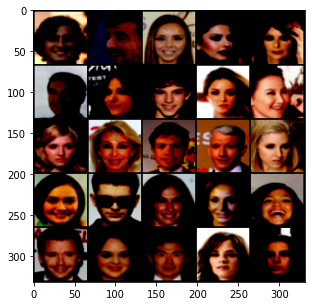

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


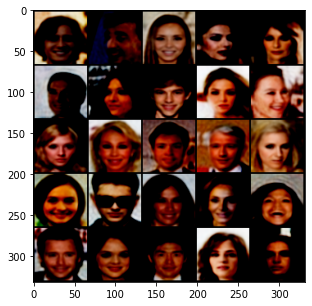

Saving Auto-Encoder model in Epoch 161 with loss=0.0063...
Saving Auto-Encoder model in Epoch 163 with loss=0.0063...
Saving Auto-Encoder model in Epoch 164 with loss=0.0063...
Saving Auto-Encoder model in Epoch 165 with loss=0.0063...
Saving Auto-Encoder model in Epoch 167 with loss=0.0062...
Saving Auto-Encoder model in Epoch 168 with loss=0.0062...
Saving Auto-Encoder model in Epoch 170 with loss=0.0062...
Saving Auto-Encoder model in Epoch 173 with loss=0.0062...
Saving Auto-Encoder model in Epoch 174 with loss=0.0061...
Saving Auto-Encoder model in Epoch 176 with loss=0.0061...
Saving Auto-Encoder model in Epoch 177 with loss=0.0061...
Saving Auto-Encoder model in Epoch 178 with loss=0.0061...
Saving Auto-Encoder model in Epoch 179 with loss=0.0061...
Epoch 180/200, loss=0.006080


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


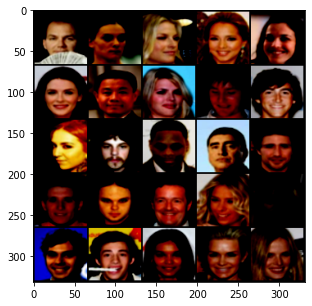

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


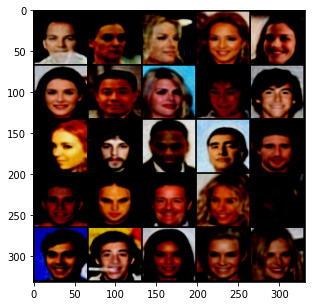

Saving Auto-Encoder model in Epoch 181 with loss=0.0060...
Saving Auto-Encoder model in Epoch 182 with loss=0.0060...
Saving Auto-Encoder model in Epoch 183 with loss=0.0060...
Saving Auto-Encoder model in Epoch 185 with loss=0.0060...
Saving Auto-Encoder model in Epoch 186 with loss=0.0060...
Saving Auto-Encoder model in Epoch 188 with loss=0.0059...
Saving Auto-Encoder model in Epoch 190 with loss=0.0059...
Saving Auto-Encoder model in Epoch 192 with loss=0.0059...
Saving Auto-Encoder model in Epoch 195 with loss=0.0059...
Saving Auto-Encoder model in Epoch 197 with loss=0.0059...
Saving Auto-Encoder model in Epoch 198 with loss=0.0059...
Saving Auto-Encoder model in Epoch 199 with loss=0.0058...
Epoch 200/200, loss=0.005862


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


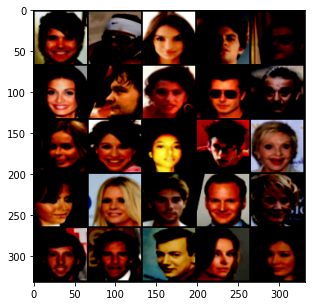

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


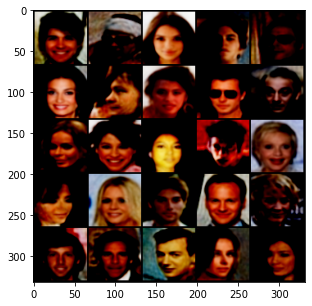

In [9]:
best_loss = np.inf
model.train()

progress_bar = tqdm(range(num_epochs), position=0, leave=True)

for epoch in progress_bar:
    progress_bar.set_description(f"Epoch {epoch+1:>03d}/{num_epochs:>03d}")
    tot_loss = list()
    for idx, data in enumerate(train_dataloader):
        # Data loading to device
        imgs = data.float().to(device)
        if model_type in ['fcn']:
            imgs = imgs.view(imgs.shape[0], -1)

        # Forward Prediction
        output = model(imgs)
        if model_type in ['fcn']:
            output = output.view(output.shape[0], -1)
            imgs = imgs.view(imgs.shape[0], -1)


        if model_type in ['vae']:
            loss = loss_vae(output[0], imgs, output[1], output[2], criterion)
        else:
            loss = criterion(output, imgs)
        tot_loss.append(loss.item())

        # Back Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Mean loss
    mean_loss = np.mean(tot_loss)

    # Save the best model
    if mean_loss < best_loss:
        best_loss = mean_loss
        print(f"Saving Auto-Encoder model in Epoch {epoch+1} with loss={mean_loss:.4f}...")
        torch.save(model, f"best_model_{model_type}.pt")

    # Progress Bar
    progress_bar.set_postfix({
        'loss': f'{mean_loss:.6f}',
    })
    if (epoch + 1) % 20 == 0 or epoch == 0 or epoch == num_epochs - 1:
        print(f'Epoch {epoch+1:>03d}/{num_epochs:>03d}, loss={mean_loss:.6f}')
        model.eval()
        with torch.no_grad():
            origin_imgs = next(iter(train_dataloader)).to(device)
            plot_sample_image(origin_imgs, grid_size=5)
            if model_type in ['fcn']:
                origin_imgs = origin_imgs.view(origin_imgs.shape[0], -1)
            reconstruct_imgs = model(origin_imgs)
            if model_type in ['fcn']:
                reconstruct_imgs = reconstruct_imgs.view(reconstruct_imgs.size(0), 3, 64, 64)
            if model_type in ['vae']:
                plot_sample_image(reconstruct_imgs[0], grid_size=5)
            else:
                plot_sample_image(reconstruct_imgs, grid_size=5)
        model.train()
    # Save last
    torch.save(model, f"last_model_{model_type}.pt")

# Inference
Model is loaded and generates its anomaly score predictions.

## Initialize
- dataloader
- model
- prediction file

In [10]:
eval_batch_size = 200

# build testing dataloader
# data = torch.tensor(test, dtype=torch.float32)
data = torch.from_numpy(test)
test_dataset = CustomTensorDataset(data, tfm)
no_tfm_dataset = CustomTensorDataset(data, no_tfm)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=eval_batch_size, num_workers=4)
eval_loss = nn.MSELoss(reduction='none')

# load trained model
checkpoint_path = f'best_model_{model_type}_083170.pt'
model = torch.load(checkpoint_path)
model.eval()

fcn_autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=12288, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=2048, bias=True)
    (4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2048, out_features=4096, bias=True)
    (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=4096, out_features=12288, bias=True)
    (4): Tanh()
  )
)

In [11]:
from torchsummary import summary
# Get the input size of training data.
input_size = None
for X in test_dataloader:
    input_size = X.view(X.size(0), -1).shape[1:]   # input_size = C * H * W
    break

# Pass model and the input size as parameters.
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 4096]      50,335,744
       BatchNorm1d-2                 [-1, 4096]           8,192
              ReLU-3                 [-1, 4096]               0
            Linear-4                 [-1, 2048]       8,390,656
       BatchNorm1d-5                 [-1, 2048]           4,096
              ReLU-6                 [-1, 2048]               0
            Linear-7                 [-1, 4096]       8,392,704
       BatchNorm1d-8                 [-1, 4096]           8,192
              ReLU-9                 [-1, 4096]               0
           Linear-10                [-1, 12288]      50,343,936
             Tanh-11                [-1, 12288]               0
Total params: 117,483,520
Trainable params: 117,483,520
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05


### Randomly sample 100 pictures in testing dataset

In [12]:
def adjust_latent(latent, alpha=0.8):
    std = latent.mul(.5)#.exp_()
    mu = latent.mean(dim=1)                                                 # Mean of each latent representation
    mu = mu.repeat(latent.shape[1]).view(latent.shape[1], -1).permute(1, 0) # Padding to match the dimensions of the latent representations.
    return latent * alpha + (1 - alpha) * mu

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


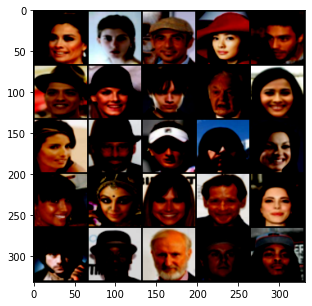

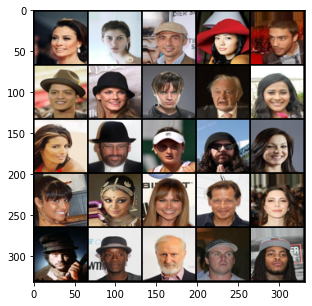

tensor([ 40.9848,  62.0342,  71.8539, 122.3371,  51.7538])
tensor([60.9449, 56.2784, 60.7176, 43.7222, 41.6638])
tensor([ 54.9322,  65.2248, 157.0344,  93.7455,  49.0559])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 62.9757, 113.2534,  81.0421,  47.9329,  40.3834])
tensor([150.8052, 109.4290,  65.3656,  38.5072,  80.0847])


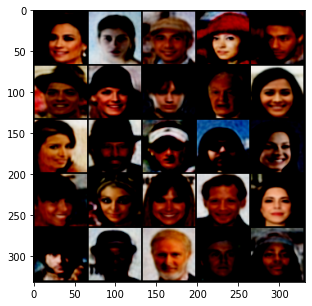

tensor([403.1602, 347.9792, 293.4724, 551.3557, 335.2972])
tensor([337.8100, 514.7836, 270.1537, 303.3643, 407.5714])
tensor([486.1867, 456.9836, 740.8725, 626.4299, 333.8427])
tensor([416.0639, 376.5709, 359.4707, 301.4167, 375.9373])
tensor([602.4302, 429.9148, 360.1310, 270.8632, 397.4460])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


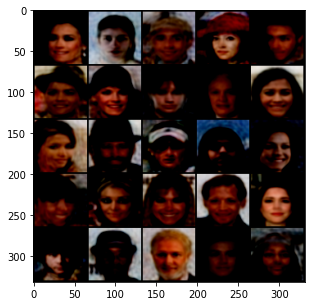

In [17]:
grid_size = 5
batch_imgs = torch.tensor([])
origin_imgs = torch.tensor([])
for idx in random.sample(range(len(test_dataset)), grid_size**2):
    batch_imgs = torch.cat((batch_imgs, test_dataset[idx]), dim=0)
    origin_imgs = torch.cat((origin_imgs, no_tfm_dataset[idx]), dim=0)
batch_imgs = torch.reshape(batch_imgs, (-1, 3, 64, 64))
batch_imgs = batch_imgs.to(device)
plot_sample_image(batch_imgs, grid_size=grid_size)
origin_imgs = torch.reshape(origin_imgs, (-1, 3, 64, 64))
plot_sample_image(origin_imgs, grid_size=grid_size)

batch_imgs = batch_imgs.view(batch_imgs.size(0), -1)
# No adjustment
output = model(batch_imgs)
for idx in range(grid_size):
    print(eval_loss(output, batch_imgs).sum([-1]).detach().cpu()[idx * grid_size: (idx + 1) * grid_size])
output = output.view(output.size(0), 3, 64, 64)
plot_sample_image(output.detach(), grid_size=grid_size)

# Adjustment
latent = model.encoder(batch_imgs)
latent = latent.view(latent.size(0), -1)
latent = adjust_latent(latent)
output = model.decoder(latent)
for idx in range(grid_size):
    print(eval_loss(output, batch_imgs).sum([-1]).detach().cpu()[idx * grid_size: (idx + 1) * grid_size])
output = output.view(output.size(0), 3, 64, 64)
plot_sample_image(output.detach(), grid_size=grid_size)

In [19]:
# prediction file 
out_file = 'prediction.csv'
anomality = list()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        img = data.float().to(device)
        img = img.view(img.shape[0], -1)
        output = model(img)
        loss = eval_loss(output, img).sum(-1)
        anomality.append(loss)
anomality = torch.cat(anomality, axis=0)
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()

df = pd.DataFrame(anomality, columns=['score'])
df.to_csv(out_file, index_label = 'ID')